# Final NeuroAI Project
## Group 1: Femke, Tikva and Gabriela

In [110]:
# Importing everything important. 
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sp
import matplotlib.image as mpimg
import os
from glob import glob
from PIL import Image
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Seting the standard seed for reproducable results

In [111]:
random.seed(10)  # any number, just for consistency

## Helper Functions


In [112]:
def load_images_from_folder(folder, image_size=(128, 128)):
    """Load grayscale images from a folder into normalized numpy arrays."""
    image_paths = []
    for ext in ('*.png', '*.jpg', '*.jpeg'):
        image_paths.extend(glob(os.path.join(folder, '**', ext), recursive=True))
    images = []
    for path in image_paths:
        img = Image.open(path).convert('L')
        img = img.resize(image_size)
        img = np.array(img, dtype=np.float32) / 255.0
        images.append(img)
    print(f"Loaded {len(images)} images from {folder}")
    return images, image_paths


def imageGenerator(imageVector):
    """Generate clean ±1 and noisy ±1 versions of an image."""
    imageVector = imageVector.astype(float)
    imageVector /= np.max(imageVector)
    cleanImage = np.where(imageVector > 0.5, 1, -1)
    noisyImage = cleanImage + np.random.normal(0, 0.8, cleanImage.shape)
    noisyImage = np.where(noisyImage >= 0, 1, -1)
    return cleanImage, noisyImage


def trainer(vector, oldCoefMat):
    """Hebbian learning: update weight matrix."""
    vector = vector.flatten()
    N = len(vector)
    coefMat = np.outer(vector, vector).astype(np.float32)
    np.fill_diagonal(coefMat, 0)
    return coefMat if np.isscalar(oldCoefMat) else oldCoefMat + coefMat


def prediction(corruptedVec, coefMat):
    """Hopfield recall: one synchronous update."""
    corruptedVec = corruptedVec.flatten()
    predictVec = np.sign(np.dot(coefMat, corruptedVec))
    predictVec[predictVec == 0] = 1  # handle zeros
    side = int(np.sqrt(len(predictVec)))
    return predictVec.reshape((side, side))


def extract_labels(image_paths):
    """Extract class labels (e.g. 'dog', 'cat') from file paths."""
    labels = []
    for path in image_paths:
        if 'dog' in path.lower():
            labels.append('dog')
        elif 'cat' in path.lower():
            labels.append('cat')
        else:
            labels.append('unknown')
    return labels

## Visualization helper function

In [113]:
def plot_image_reconstruction(selected_images, selected_labels, coefMatrix, imageGenerator, prediction, save_path=None):
    """
    Plot Original, Cleaned, Noisy, and Recalled images for each selected image.
    
    Parameters
    ----------
    selected_images : list of np.ndarray
        List of images (grayscale, as numpy arrays).
    selected_labels : list of str
        Corresponding labels for the images (e.g., 'dog', 'cat').
    coefMatrix : np.ndarray
        Hopfield network weight matrix after training.
    imageGenerator : function
        Function that generates (cleanImage, noisyImage) from an input image.
    prediction : function
        Function that recalls an image given a noisy input and the weight matrix.
    save_path : str or None
        Optional file path to save the resulting figure. If None, figure is only shown.
    """
    n_images = len(selected_images)
    plt.figure(figsize=(15, 5 * n_images))

    for i, img in enumerate(selected_images):
        clean, noisyVec = imageGenerator(img)
        predictedVec = prediction(noisyVec, coefMatrix)

        # --- Original ---
        plt.subplot(n_images, 4, 4 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Original ({selected_labels[i]})')
        plt.axis('off')

        # --- Cleaned ---
        plt.subplot(n_images, 4, 4 * i + 2)
        plt.imshow(clean, cmap='gray')
        plt.title('Cleaned')
        plt.axis('off')

        # --- Noisy ---
        plt.subplot(n_images, 4, 4 * i + 3)
        plt.imshow(noisyVec, cmap='gray')
        plt.title('Noisy')
        plt.axis('off')

        # --- Recalled ---
        plt.subplot(n_images, 4, 4 * i + 4)
        plt.imshow(predictedVec, cmap='gray')
        plt.title('Recalled')
        plt.axis('off')


    plt.tight_layout()

    # --- Save before showing ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()
    plt.close()


## Main Experiment

In [1]:
# ============================================================
# 2. Main Experiment
# ============================================================

train_dir = "data/train"
test_dir  = "data/test"

train_images, train_paths = load_images_from_folder(train_dir)
test_images, test_paths   = load_images_from_folder(test_dir)
# test_images = random.sample(test_images, 70)
# test_paths  = random.sample(test_paths, 70)

train_labels = extract_labels(train_paths)
test_labels  = extract_labels(test_paths)

train_counts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   # “learning opportunities”
results = []

conf_matrices = []
train_labels_list = []

for n_train in train_counts:
    print(f"\n=== Training with {n_train} patterns ===")
    selected_indices = random.sample(range(len(train_images)), n_train)
    selected_images = [train_images[i] for i in selected_indices]
    selected_labels = [train_labels[i] for i in selected_indices]
    coefMatrix = 0
    stored_patterns = []

    # --- Hebbian learning phase ---
    for i, img in enumerate(selected_images):
        clean, noisyVec = imageGenerator(img)
        coefMatrix = trainer(clean, 0 if i == 0 else coefMatrix)
        stored_patterns.append(clean)

    # --- Visualization ---

    plot_image_reconstruction(
    selected_images=selected_images,
    selected_labels=selected_labels,
    coefMatrix=coefMatrix,
    imageGenerator=imageGenerator,
    prediction=prediction,
    save_path= f"hopfield_stage_{n_train}.png"
    )

    # --- Recall / classification test phase ---
    y_true, y_pred = [], []
    for test_img, true_label in zip(test_images, test_labels):
        clean, noisy = imageGenerator(test_img)
        recalled = prediction(noisy, coefMatrix)

        # Compare recalled pattern with all stored patterns
        similarities = [np.mean(recalled == p) for p in stored_patterns]
        best_match_idx = np.argmax(similarities)
        predicted_label = selected_labels[best_match_idx]

        y_true.append(true_label)
        y_pred.append(predicted_label)

    cm = confusion_matrix(y_true, y_pred, labels=['dog', 'cat'])
    conf_matrices.append(cm)
    train_labels_list.append(n_train)

    # --- Accuracy ---
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    results.append(accuracy)
    print(f"Classification accuracy with {n_train} training images: {accuracy:.2f}")

NameError: name 'load_images_from_folder' is not defined

## Plotting learning improvement


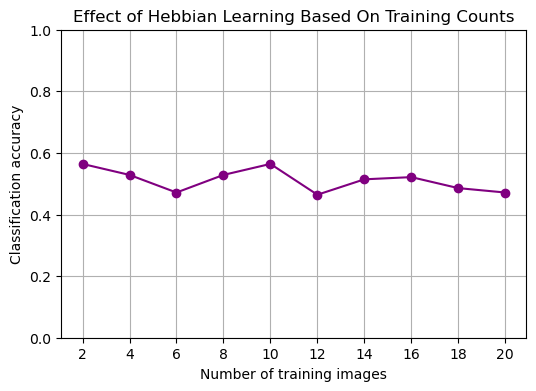

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_counts, results, color='purple', marker='o')
plt.title("Effect of Hebbian Learning Based On Training Counts")
plt.xlabel("Number of training images")
plt.xticks(train_counts)
plt.ylabel("Classification accuracy")
plt.ylim(0,1)
plt.grid(True)
# plt.savefig("hebbian_learning_curve.png")
plt.show()


## Plotting all the confusion matrices together

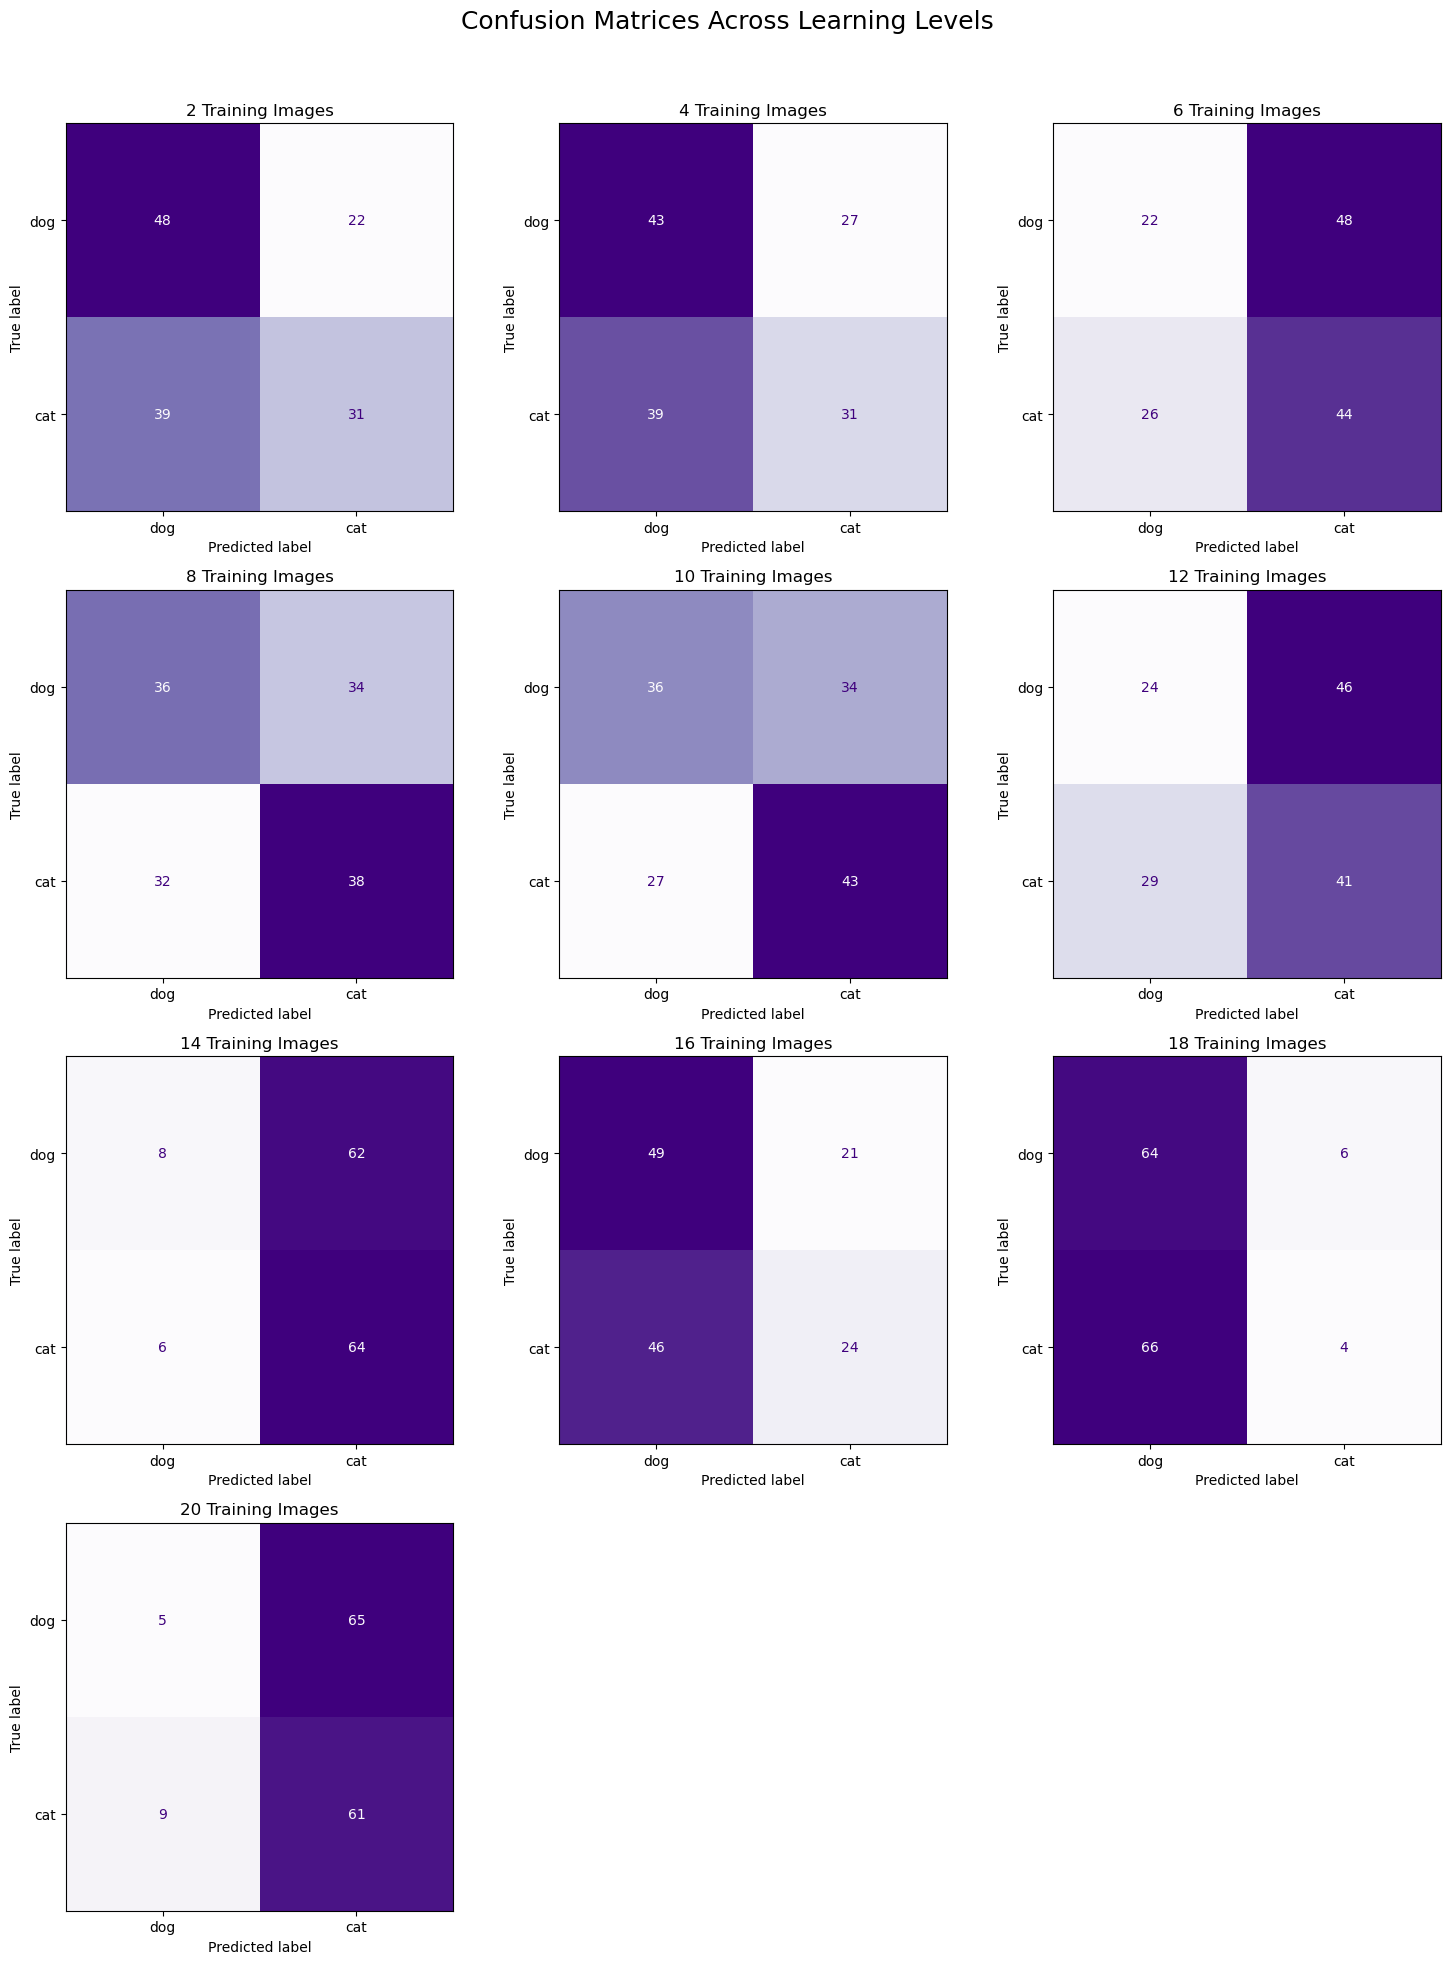

In [ ]:
# ============================================================
# 7. Plot all confusion matrices together
# ============================================================
num_models = len(conf_matrices)

# --- Choose layout automatically ---
cols = 3                                   # number of columns per row
rows = int(np.ceil(num_models / cols))     # number of rows needed

plt.figure(figsize=(5 * cols, 5 * rows))

for i, (cm, n_train) in enumerate(zip(conf_matrices, train_labels_list)):
    ax = plt.subplot(rows, cols, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['dog', 'cat'])
    disp.plot(cmap='Purples', values_format='d', ax=ax, colorbar=False)
    ax.set_title(f'{n_train} Training Images')

plt.suptitle("Confusion Matrices Across Learning Levels", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Original Code 
#### From: https://github.com/nosratullah/hopfieldNeuralNetwork?tab=readme-ov-file

In [ ]:
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sp
import matplotlib.image as img

# import the image and extract
def imageGenerator(imageVector):
    cleanImage = np.zeros([len(imageVector)-1,len(imageVector)-1])
    for i in range(len(imageVector)-1):
        for j in range(len(imageVector)-1):
            if (imageVector[i][j] > 1):
                cleanImage[i][j] = 1
            else:
                cleanImage[i][j] = -1
    noisyImage = cleanImage + np.random.normal(0, 2, [len(image)-1,len(image)-1])

    for i in range(len(image)-1):
        for j in range(len(image)-1):
            if (noisyImage[i][j] >= 0):
                noisyImage[i][j] = 1
            else:
                noisyImage[i][j] = -1

    return cleanImage,noisyImage
# Building up the coefficient matrix
def trainer(vector,oldCoefMat):
    vector = vector.flatten()
    coefMat = np.zeros([len(vector)-1,len(vector)-1])
    if (np.isscalar(oldCoefMat)):
        for i in range(len(vector)-1):
            for j in range(len(vector)-1):
                if (i!=(i-j)):
                    coefMat[i][i-j] = vector[i]*vector[i-j]
    if (np.shape(oldCoefMat) == np.shape(coefMat)):
        for i in range(len(vector)-1):
            for j in range(len(vector)-1):
                if (i!=(i-j)):
                    coefMat[i][i-j] = vector[i]*vector[i-j]
        coefMat = coefMat + oldCoefMat

    vector = np.reshape(vector, [int(np.sqrt(len(vector))),int(np.sqrt(len(vector)))])
    return coefMat

#
def prediction(curuptedVec,coefMat):
    curuptedVec = curuptedVec.flatten()
    predictVec = np.zeros(len(curuptedVec))
    for i in range(len(curuptedVec)-1):
        temp = 0
        for j in range(len(curuptedVec)-1):
             temp += coefMat[i][j] * curuptedVec[j]
        if (temp>0):
            predictVec[i] = 1
        if (temp<0):
            predictVec[i] = -1

    predictVec = np.reshape(predictVec, [int(np.sqrt(len(predictVec))),int(np.sqrt(len(predictVec)))])
    return predictVec


#Import the images
plt.figure(figsize=(15,10))
for i in range(1,4):
    image = img.imread('dataset/pgms/{}.png'.format(i),'w').copy()
    if (i==1):
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,0)
        predictedVec = prediction(noisyVec,coefMatrix)
    else:
        vector,noisyVec = imageGenerator(image)
        coefMatrix = trainer(vector,coefMatrix)
        predictedVec = prediction(noisyVec,coefMatrix)

    plt.subplot(i,4,1)
    plt.imshow(image)
    plt.title('Imported Picture 1')
    plt.subplot(i,4,2)
    plt.imshow(vector);
    plt.title('Cleaned and Squared Picture 1')
    plt.subplot(i,4,3)
    plt.imshow(noisyVec);
    plt.title('Noisy Picture 1')
    plt.subplot(i,4,4)
    plt.imshow(predictedVec);
    plt.title('Recalled Picture 1')

plt.savefig('hopfields.png')
plt.clf()
plt.imshow(coefMatrix)
plt.savefig('matrix.png')
plt.title('Coefficient Matrix')
plt.show()
"""

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport scipy.misc as sp\nimport matplotlib.image as img\n\n# import the image and extract\ndef imageGenerator(imageVector):\n    cleanImage = np.zeros([len(imageVector)-1,len(imageVector)-1])\n    for i in range(len(imageVector)-1):\n        for j in range(len(imageVector)-1):\n            if (imageVector[i][j] > 1):\n                cleanImage[i][j] = 1\n            else:\n                cleanImage[i][j] = -1\n    noisyImage = cleanImage + np.random.normal(0, 2, [len(image)-1,len(image)-1])\n\n    for i in range(len(image)-1):\n        for j in range(len(image)-1):\n            if (noisyImage[i][j] >= 0):\n                noisyImage[i][j] = 1\n            else:\n                noisyImage[i][j] = -1\n\n    return cleanImage,noisyImage\n# Building up the coefficient matrix\ndef trainer(vector,oldCoefMat):\n    vector = vector.flatten()\n    coefMat = np.zeros([len(vector)-1,len(vector)-1])\n    if (np.isscalar(oldCoefMat)):\n    